In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
csv = 'clean_tweet.csv'
dataf = pd.read_csv(csv,index_col=0)
dataf.head()

c:\users\bhumika\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,text,target
0,awww that bummer you shoulda got david carr of...,0
1,is upset that he can not update his facebook b...,0
2,dived many times for the ball managed to save ...,0
3,my whole body feels itchy and like its on fire,0
4,no it not behaving at all mad why am here beca...,0


In [6]:
dataf.dropna(inplace=True)
dataf.reset_index(drop=True,inplace=True)
dataf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1596035 entries, 0 to 1596034
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   text    1596035 non-null  object
 1   target  1596035 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


# Splitting the dataset into train,validation and test sets

In [24]:
x = dataf.text
y = dataf.target
from sklearn.model_selection import train_test_split
SEED = 2000
x_train, x_valid_and_test, y_train, y_valid_and_test = train_test_split(x,y, test_size = 0.02, random_state = SEED)
x_valid, x_test, y_valid, y_test = train_test_split(x_valid_and_test,y_valid_and_test, test_size = 0.5, random_state = SEED)


print("Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_train),
                                                                             (len(x_train[y_train == 0]) / (len(x_train)*1.))*100,
                                                                            (len(x_train[y_train == 1]) / (len(x_train)*1.))*100))
print("Validation set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_valid),
                                                                             (len(x_valid[y_valid == 0]) / (len(x_valid)*1.))*100,
                                                                            (len(x_valid[y_valid == 1]) / (len(x_valid)*1.))*100))
print("Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_test),
                                                                             (len(x_test[y_test == 0]) / (len(x_test)*1.))*100,
                                                                            (len(x_test[y_test == 1]) / (len(x_test)*1.))*100))

Train set has total 1564114 entries with 50.00% negative, 50.00% positive
Validation set has total 15960 entries with 50.09% negative, 49.91% positive
Test set has total 15961 entries with 50.69% negative, 49.31% positive


# Accuracy using TextBlob

In [26]:
from textblob import TextBlob
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

tbres = [TextBlob(i).sentiment.polarity for i in x_valid]
tbpred = [0 if n<0 else 1 for n in tbres]

conmat = np.array(confusion_matrix(y_valid, tbpred, labels=[1,0]))
confusion = pd.DataFrame(conmat, index=['positive', 'negative'],
                         columns=['predicted_positive','predicted_negative'])
print("Accuracy Score: {0:.2f}%".format(accuracy_score(y_valid, tbpred)*100))
print("-"*80)
print("Confusion Matrix\n")
print(confusion)

Accuracy Score: 60.92%
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_positive  predicted_negative
positive                7188                 778
negative                5459                2535


In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
@ignore_warnings(category=ConvergenceWarning)

def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("accuracy score: {0:.2f}%".format(accuracy*100))
    print("-"*80)
    return accuracy

In [41]:
tvec = TfidfVectorizer()
lr = LogisticRegression()
n_features = np.arange(10000,100001,10000)

def nfeature_accuracy_checker(vectorizer, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=lr):
    result = []
    print(classifier)
    print("\n")
    for n in n_features:
        vectorizer.set_params(stop_words = stop_words, max_features = n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print("Validation result for {} features".format(n))
        nfeature_accuracy = accuracy_summary(checker_pipeline, x_train, y_train, x_valid, y_valid)
        result.append((n,nfeature_accuracy))
    return result

In [44]:
print("RESULT FOR UNIGRAM WITH STOP WORDS (Tfidf)\n")
feature_result_ugt = nfeature_accuracy_checker(vectorizer=tvec)
print("RESULT FOR BIGRAM WITH STOP WORDS (Tfidf)\n")
feature_result_bgt = nfeature_accuracy_checker(vectorizer=tvec,ngram_range=(1, 2))
print("RESULT FOR TRIGRAM WITH STOP WORDS (Tfidf)\n")
feature_result_tgt = nfeature_accuracy_checker(vectorizer=tvec,ngram_range=(1, 3))

RESULT FOR UNIGRAM WITH STOP WORDS (Tfidf)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


Validation result for 10000 features
accuracy score: 79.95%
--------------------------------------------------------------------------------
Validation result for 20000 features
accuracy score: 80.19%
--------------------------------------------------------------------------------
Validation result for 30000 features
accuracy score: 80.23%
--------------------------------------------------------------------------------
Validation result for 40000 features
accuracy score: 80.23%
--------------------------------------------------------------------------------
Validation result for 50000 features
accuracy score: 80.25%
----

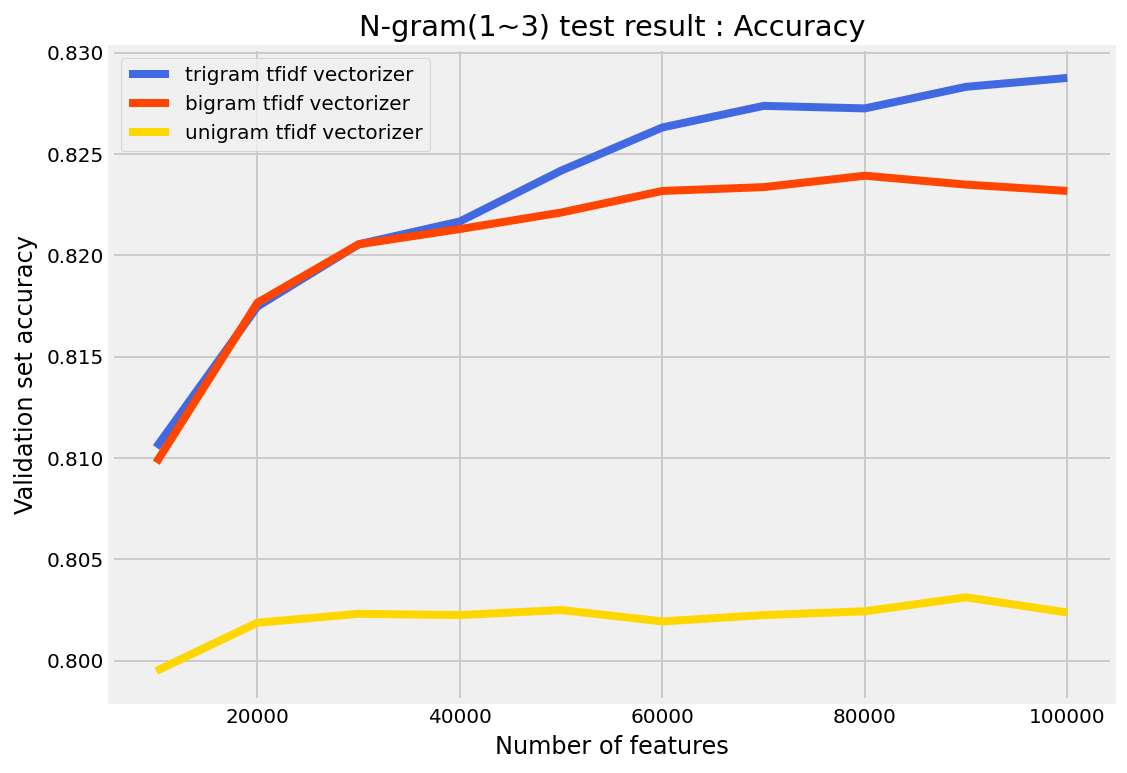

In [43]:
nfeatures_plot_tgt = pd.DataFrame(feature_result_tgt,columns=['nfeatures','validation_accuracy'])
nfeatures_plot_bgt = pd.DataFrame(feature_result_bgt,columns=['nfeatures','validation_accuracy'])
nfeatures_plot_ugt = pd.DataFrame(feature_result_ugt,columns=['nfeatures','validation_accuracy'])

plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_tgt.nfeatures, nfeatures_plot_tgt.validation_accuracy,label='trigram tfidf vectorizer',color='royalblue')
plt.plot(nfeatures_plot_bgt.nfeatures, nfeatures_plot_bgt.validation_accuracy,label='bigram tfidf vectorizer',color='orangered')
plt.plot(nfeatures_plot_ugt.nfeatures, nfeatures_plot_ugt.validation_accuracy, label='unigram tfidf vectorizer',color='gold')

plt.title("N-gram(1~3) test result : Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()